In [1]:
import numpy as np
from scipy import signal
from scipy import fftpack
from matplotlib import pyplot as plt
from loadTDMS import *

In [96]:
#バターワースフィルタ（ハイパス）
def highpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2#ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    print(wp,ws)
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    print(N,Wn)
    b, a = signal.butter(N, Wn, "high")           #フィルタ伝達関数の分子と分母を計算
    print(b,a)
    y = signal.filtfilt(b, a, x)                #信号に対してフィルタをかける
    print(y)
    return y                                      #フィルタ後の信号を返す

# オーバーラップ処理
def ov(data, samplerate, Fs, overlap):
#     print("data", data)
#     print("samplerate", samplerate)
#     print("Fs", Fs)
#     print("overlap", overlap)
    Ts = len(data) / samplerate                                                # 全データ長
    print("Ts", Ts)
    Fc = Fs / samplerate                                                       # フレーム周期
    print("Fc", Fc)
    x_ol = Fs * (1 - (overlap / 100))                                          # オーバーラップ時のフレームずらし幅
    N_ave = int((Ts - (Fc * (overlap / 100))) / (Fc * (1 - (overlap / 100))))  # 抽出するフレーム数（平均化に使うデータ個数）
    print("x_ol", x_ol)
    print("N_ave", N_ave)
    array = []                                                                 # 抽出したデータを入れる空配列の定義
 
    # forループでデータを抽出
    for i in range(N_ave):
        ps = int(x_ol * i)                                                     # 切り出し位置をループ毎に更新
        array.append(data[ps:ps + Fs:1])                                       # 切り出し位置psからフレームサイズ分抽出して配列に追加
    return array, N_ave                                                        # オーバーラップ抽出されたデータ配列とデータ個数を戻り値にする
 
# 窓関数処理（ハニング窓）
def hanning(data_array, Fs, N_ave):
    han = signal.hann(Fs)                    # ハニング窓作成
    acf = 1 / (sum(han) / Fs)                # 振幅補正係数(Amplitude Correction Factor)
#     print('aaaa', data_array)
    # オーバーラップされた複数時間波形全てに窓関数をかける
    for i in range(N_ave):
        data_array[i] = data_array[i] * han  # 窓関数をかける
 
    return data_array, acf

In [74]:
# FFT処理
def fft_ave(data_array, samplerate, Fs, N_ave, acf):
    fft_array = []
#     print(data_array, samplerate, Fs, N_ave, acf)
    for i in range(N_ave):
        fft_array.append(acf * np.abs(fftpack.fft(data_array[i]) / (Fs / 2)))  # FFTをして配列に追加、窓関数補正値をかけ、(Fs/2)の正規化を実施。
 
    fft_axis = np.linspace(0, samplerate, Fs)                                  # 周波数軸を作成
    fft_array = np.array(fft_array)                                            # 型をndarrayに変換
    fft_mean = np.mean(fft_array, axis=0)                                      # 全てのFFT波形の平均を計算
 
    return fft_array, fft_mean, fft_axis

In [48]:
#リニア値からdBへ変換
def db(x, dBref):
    y = 20 * np.log10(x / dBref)     #変換式
    return y                         #dB値を返す

In [94]:
# ここからサンプル波形生成とフィルタ処理をする-------------------------------------------
path = r'C:\Users\pmg07\Desktop\2021_1115_切削実験\ae\AE_368.tdms'
samplerate = 10**6
data = load_tdms(path, ch_num=3)    # ガウシアンノイズを生成
N = len(data[0][5000000:5016385])
x = np.linspace(0, N/samplerate, N)

fp = 4*10**5                                               # 通過域端周波数[Hz]
fs = 3*10**5                                               # 阻止域端周波数[Hz]
gpass = 40                                               # 通過域端最大損失[dB]
gstop = 120                                              # 阻止域端最小損失[dB]
 
# ハイパスをかける関数を実行
data_filt = highpass(data[0][5000000:5016385], samplerate, fp, fs, gpass, gstop)
print(len(data_filt))

0.8 0.6
12 0.861310474693027
[ 2.56342909e-09 -3.07611491e-08  1.69186320e-07 -5.63954401e-07
  1.26889740e-06 -2.03023584e-06  2.36860848e-06 -2.03023584e-06
  1.26889740e-06 -5.63954401e-07  1.69186320e-07 -3.07611491e-08
  2.56342909e-09] [1.00000000e+00 8.66310526e+00 3.47548190e+01 8.53038776e+01
 1.42559667e+02 1.70787101e+02 1.50312030e+02 9.78775107e+01
 4.67797740e+01 1.59979906e+01 3.71469874e+00 5.25668192e-01
 3.42747473e-02]
[ 3.70241616e-06  6.77518662e-05 -1.34174147e-04 ...  6.13829300e-05
 -1.76651892e-05 -2.53456350e-05]
16385


In [97]:
# ここから平均化フーリエ変換とデシベル変換を行う----------------------------------------------
Fs = 4096                               # フレームサイズ
overlap = 50                            # オーバーラップ率
 
# 作成した関数を実行：オーバーラップ抽出された時間波形配列
t_array_org, N_ave_org = ov(data, samplerate, Fs, overlap)
print(t_array_org, N_ave_org)
t_array_filt, N_ave_filt = ov(data_filt, samplerate, Fs, overlap)
# print(t_array_filt, N_ave_filt)

# 作成した関数を実行：ハニング窓関数をかける
t_array_org, acf_org = hanning(t_array_org, Fs, N_ave_org)
t_array_filt, acf_filt = hanning(t_array_filt, Fs, N_ave_filt)

# print(t_array_org)
# print(acf_filt)
# 作成した関数を実行：FFTをかける
fft_array_org, fft_mean_org, fft_axis_org = fft_ave(t_array_org, samplerate, Fs, N_ave_org, acf_org)
fft_array_filt, fft_mean_filt, fft_axis_filt = fft_ave(t_array_filt, samplerate, Fs, N_ave_filt, acf_filt)

# print(fft_array_org)

# dB変換する
fft_mean_org = db(fft_mean_org, 2e-5)
fft_mean_filt = db(fft_mean_filt, 2e-5)

Ts 3e-06
Fc 0.004096
x_ol 2048.0
N_ave 0
[] 0
Ts 0.016385
Fc 0.004096
x_ol 2048.0
N_ave 7


C:\Users\pmg07\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\pmg07\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
print(fft_array_org)

[]


ValueError: x and y must have same first dimension, but have shapes (16385,) and (15649026,)

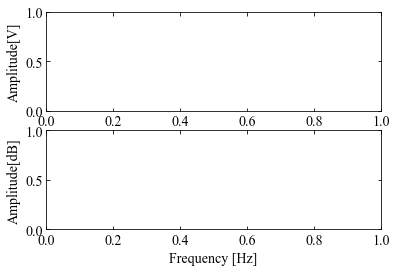

In [57]:
# ここからグラフ描画---------------------------------------------------------------------
# フォントの種類とサイズを設定する。
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'
 
# 目盛を内側にする。
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
 
# グラフの上下左右に目盛線を付ける。
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax2 = fig.add_subplot(212)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
 
# 軸のラベルを設定する。
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude[V]')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude[dB]')

# データプロットの準備とともに、ラベルと線の太さ、凡例の設置を行う。
ax1.plot(x, data[0], label='original', lw=1)
ax1.plot(x, data_filt, label='filtered', lw=1)
ax2.plot(fft_axis_org)
ax2.plot(fft_axis_org, fft_mean_org, label='original', lw=1)
ax2.plot(fft_axis_filt, fft_mean_filt, label='filtered', lw=1)
plt.legend()
 
# 軸のリミットを設定する。
ax2.set_xlim(0, max(fft_axis_org)/2)
ax2.set_ylim(-20, 100)
 
# レイアウト設定
fig.tight_layout()